# Classification

PreFace:
Dear Professor Zhang and TA Mr.Yin:
In xgboost, it is not only time-consuming but also impossible to check the ratio of completion while finetuning. Due to these two inconveniences, I do not use gridsearchcv. Instead, I choose to test each parameter in each value separately, so that I can better control the process.

In [1]:
import pandas as pd
import numpy as np
import sys 
import statsmodels as sm
import sklearn
import scipy as sp
%matplotlib inline 
import matplotlib.pyplot as plt
import math
import warnings;
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.linear_model import LinearRegression as LinReg
import xgboost as xgb
from sklearn.model_selection import train_test_split as tr_te_split
from sklearn.linear_model import LogisticRegression as LogitReg
from sklearn.model_selection import GridSearchCV

# (a)Data Pre-processing

In [8]:
df1=pd.read_csv('dataframe_train.csv')
df2=pd.read_csv('dataframe_test.csv')

From my gut feelings, I pick up features as follow: 'source_type','grid_distance','target_lng','target_lat','urgency','source_lat','source_lng'

In [9]:
#to transform the ['action_type'] in test data into binary:
def dummy(x):
    if x == 'PICKUP':
        return 0
    else:
        return 1

In [10]:
from sklearn.metrics import confusion_matrix
def F(x,y):#(y_train,y_pred)
    tn,fp, fn, tp = confusion_matrix(x,y).ravel()
    return(2*tp/(2*tp+fp+fn))

Pick up several relevant variables.

Our aim is to forecast 25000 rows of data with 500,000 rows of data.
Therefore, I built a train-test split in the ratio of 484136:25468, which approximates the final ratio.

In [11]:
df3=df1[['source_type','grid_distance','target_lng','target_lat','urgency','source_lng','source_lat','action_type']]
df3=pd.get_dummies(df3,columns=['source_type'])
df3['action_type']=df3['action_type'].apply(lambda x: dummy(x))
df_train=df3[0:484136]
df_test=df3[484136:]

Get rid of some of the ourliers.

In [12]:
Q3=df1.urgency.quantile(0.75)
Q1=df1.urgency.quantile(0.25)
IQR=Q3-Q1
lower_limit=Q1-1.5*IQR
upper_limit=Q3+1.5*IQR

In [13]:
X_train=df_train[(df_train['urgency']>=lower_limit)&(df_train['urgency']<=upper_limit)].drop(columns=['action_type'])
y_train=df_train[(df_train['urgency']>=lower_limit)&(df_train['urgency']<=upper_limit)]['action_type'].ravel()
X_test=df_test.drop(columns=['action_type'])
y_test=df_test['action_type'].ravel()

# (b)Baseline Model(Logistic Regression)

In [35]:
#LR = LogitReg().fit(X_train,y_train)

In [36]:
param_grid_2 = [{'C':np.arange(0.01,1,0.01),
               }]#LogisticRegression里面的range用C来表示.线性回归里面用alpha来表示
Ridge_LinReg = LogitReg('l2',solver='liblinear',max_iter=1000)
grid_2 = GridSearchCV(Ridge_LinReg, param_grid_2, cv=5)
grid_2.fit(X_train,y_train.ravel())
print("The best alpha parameter is",grid_2.best_params_) 
print('\n') 
print("The corresponding R-squared is %0.4f." % grid_2.best_score_) 

The best alpha parameter is {'C': 0.93}


The corresponding R-squared is 0.7352.


In [37]:
param_grid_2 = [{'C':np.arange(0.1,1,0.1),
               }]#LogisticRegression里面的range用C来表示.线性回归里面用alpha来表示
Ridge_LinReg = LogitReg('l2',solver='newton-cg',max_iter=1000)
grid_2 = GridSearchCV(Ridge_LinReg, param_grid_2, cv=5)
grid_2.fit(X_train,y_train.ravel())
print("The best alpha parameter is",grid_2.best_params_) 
print('\n') 
print("The corresponding R-squared is %0.4f." % grid_2.best_score_) 

The best alpha parameter is {'C': 0.1}


The corresponding R-squared is 0.7350.


In [38]:
LR=LogitReg(penalty='l2', C=0.93, solver='liblinear').fit(X_train,y_train)
prob_pred = LR.predict_proba(X_test)
t = 0.5
y_pred = np.array(list(map(lambda x: int(x>=t), prob_pred[:, 1])))

In [39]:
F(y_test,y_pred)

0.727109234498397

Now try the model in kaggle.

In [5]:
df1=pd.read_csv('dataframe_train.csv')
df2=pd.read_csv('dataframe_test.csv')
df_LR=df1[['source_type','grid_distance','target_lng','target_lat','urgency','source_lng','source_lat','action_type']]
df_LR=pd.get_dummies(df_LR,columns=['source_type'])
df_LR['action_type'].apply(lambda x: dummy(x))
X_test_final=df2[['source_type','grid_distance','target_lng','target_lat','urgency','source_lng','source_lat']]
X_test_final=pd.get_dummies(X_test_final,columns=['source_type'])
X_train_final=df_LR.drop(columns=['action_type'])
y_train_final=df_LR['action_type'].apply(lambda x: dummy(x))

In [41]:
LR_final=LogitReg(penalty='l2', C=0.93, solver='liblinear').fit(X_train_final,y_train_final)
prob_pred = LR.predict_proba(X_test_final)
t = 0.5
y_pred = np.array(list(map(lambda x: int(x>=t), prob_pred[:, 1])))

In [24]:
df_classification = pd.read_csv("classification1.csv",index_col = 0)
df_classification["action_type_DELIVERY"] = y_pred
df_classification.to_csv("classification_LR.csv")

And the F1-score on kaggle is: 0.71589

# (c)Gradient Boosting Tree (Xgboost)

In [13]:
data_train = xgb.DMatrix(data=X_train,label= y_train)
#data_test = xgb.DMatrix(data=X_test,label= y_test)

In [20]:
kuaidi_xgbt = xgb.XGBClassifier(objective ='binary:logistic',
                                eval_metric='logloss',
                                colsample_bynode=0.9,
                                learning_rate = 0.3,gamma = 0.01,
                                max_depth = 18,
                                n_estimators = 500,
                                use_label_encoder=False)

In [21]:
from sklearn.metrics import confusion_matrix
kuaidi_xgbt.fit(X_train,y_train)
y_pred = kuaidi_xgbt.predict(X_test)

In [16]:
#Result of Benchmark parameters 0.8 0.1 0.001 20 200
F(y_test,y_pred)

0.9390819722888768

Testing max_depth

In [56]:
F(y_test,y_pred) #max_depth=21

0.9380112424888545

In [28]:
F(y_test,y_pred) #max_depth=20

0.9390819722888768

In [31]:
F(y_test,y_pred) #max_depth=10

0.9020726373835329

In [52]:
F(y_test,y_pred) #max_depth=17

0.9361307522893242

In [49]:
F(y_test,y_pred) #max_depth=18 colsample_bynode=0.8

0.9404844826251838

In [46]:
F(y_test,y_pred) #max_depth=19

0.9391876208897485

The optimal max_depth=18

Testing colsample_bynode

In [61]:
F(y_test,y_pred) #0.8

0.9404844826251838

In [64]:
F(y_test,y_pred) #0.7

0.9367362722351121

In [67]:
F(y_test,y_pred) #0.6

0.9361339986847704

In [70]:
F(y_test,y_pred) #max_depth=18 colsample_bynode=0.9 learning_rate=0.1

0.9408622958433315

In [73]:
F(y_test,y_pred) #1.0

0.9386745031320084

The optimal colsample_bynode=0.9

Testing learning rate.

In [80]:
F(y_test,y_pred) #0.05

0.9165804498601372

In [83]:
F(y_test,y_pred) #max_depth=18 colsample_bynode=0.9 learning_rate=0.3 n_estimator=200

0.9550737071991264

The optimal learning_rate=0.3

In [86]:
F(y_test,y_pred) #n_estimator=100

0.945784069695084

In [89]:
F(y_test,y_pred) #n_estimator=50

0.9276595744680851

In [92]:
F(y_test,y_pred) #n_estimator=300

0.9586131500858972

In [95]:
F(y_test,y_pred) #n_estimator=400

0.9604188645332709

In [98]:
F(y_test,y_pred) #max_depth=18 colsample_bynode=0.9 learning_rate=0.3 n_estimator=500 #gamma=0.001

0.9612378868396374

The optimal n_estimator=500

In [22]:
F(y_test,y_pred) #max_depth=18 colsample_bynode=0.9 learning_rate=0.3 n_estimator=500 #gamma=0.01

0.9632783811235253

In [104]:
F(y_test,y_pred) #0.05

0.9628241174632928

In [107]:
F(y_test,y_pred) #0.03

0.9628125

The optimal gamma=0.01

The optimal parameters are colsample_bynode=0.9, learning_rate=0.3, gamma=0.01, max_depth=18, n_estimators=500.

Now try the kaggle.

In [114]:
data_train = xgb.DMatrix(data=X_train_final,label= y_train_final)

In [119]:
kuaidi_xgbt.fit(X_train_final,y_train_final)
y_pred_final = kuaidi_xgbt.predict(X_test_final)

In [120]:
df_classification = pd.read_csv("classification1.csv",index_col = 0)
df_classification["action_type_DELIVERY"] = y_pred_final
df_classification.to_csv("classification-xgboost.csv")

After modification, the f1-score in kaggle goes to 0.96582

# (d)Further Feature Engineering

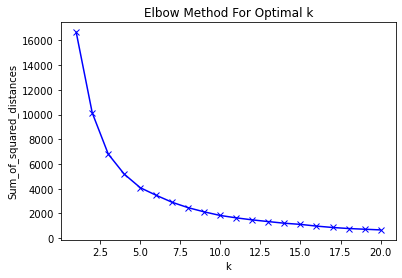

In [14]:
from sklearn.cluster import KMeans
def fitting(df):
    Sum_of_squared_distances = []
    K = range(1,21)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(df)
        Sum_of_squared_distances.append(km.inertia_)
        #inertia_ reports the within group sum of squared errors, which is W in this Jupyter.
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    return 

fitting(X_train[['source_lng','source_lat']])

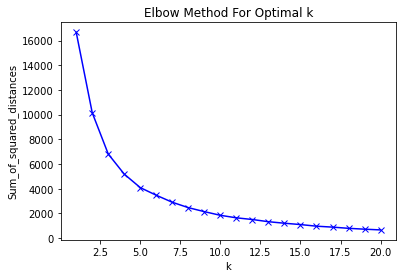

In [46]:
from sklearn.cluster import KMeans
def fitting(df):
    Sum_of_squared_distances = []
    K = range(1,21)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(df)
        Sum_of_squared_distances.append(km.inertia_)
        #inertia_ reports the within group sum of squared errors, which is W in this Jupyter.
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    return 

fitting(X_train[['target_lng','target_lat']])

In [55]:
kmeans1 = KMeans(n_clusters=5, random_state=666, max_iter=1000,init='k-means++').fit(X_train[['source_lng','source_lat']])
print(kmeans1.labels_)

kmeans2 = KMeans(n_clusters=5, random_state=666, max_iter=1000,init='k-means++').fit(X_train[['target_lng','target_lat']])
print(kmeans2.labels_)

[4 4 4 ... 4 4 4]
[1 1 1 ... 1 1 1]


In [56]:
kmeans3 = KMeans(n_clusters=5, random_state=666, max_iter=1000,init='k-means++').fit(X_test[['source_lng','source_lat']])
print(kmeans1.labels_)

kmeans4 = KMeans(n_clusters=5, random_state=666, max_iter=1000,init='k-means++').fit(X_test[['target_lng','target_lat']])
print(kmeans2.labels_)

[4 4 4 ... 4 4 4]
[1 1 1 ... 1 1 1]


In [57]:
e=pd.DataFrame(kmeans1.labels_)
f=pd.DataFrame(kmeans2.labels_)
g=pd.DataFrame(kmeans3.labels_)
h=pd.DataFrame(kmeans4.labels_)

In [64]:
X_train_FE=X_train.copy()
X_test_FE=X_test.copy()
X_train_FE['source_integrated'],X_train_FE['target_integrated']=e,f
X_test_FE['source_integrated'],X_test_FE['target_integrated']=g,h

Now fine if our in-sample f1-score is higher.

In [68]:
data_train = xgb.DMatrix(data=X_train,label= y_train)

In [125]:
kuaidi_xgbt = xgb.XGBClassifier(objective ='binary:logistic', eval_metric='logloss',
                                colsample_bynode=1.0,
                                learning_rate = 0.3,
                                gamma = 0.001,
                                max_depth = 15,
                                n_estimators = 500,
                                use_label_encoder=False)

In [126]:
kuaidi_xgbt.fit(X_train,y_train)
y_pred = kuaidi_xgbt.predict(X_test)

Now let's finetune.

Test max_depth first, bench mark is max_depth = 18.(range:10~20)

In [72]:
F(y_test,y_pred) #0.9 0.3 0.01 18 500

0.9606120935316391

In [75]:
F(y_test,y_pred) #20

0.9604908359060533

In [78]:
F(y_test,y_pred)#10

0.9577047518808717

In [82]:
F(y_test,y_pred)#5

0.9065499500883053

In [85]:
F(y_test,y_pred)#max_depth = 15, n_estimators = 500. learning_rate = 0.3. colsample_bynode=0.9. gamma=0.01

0.9630382915476982

In [88]:
F(y_test,y_pred)#14

0.9625580759770429

In [91]:
F(y_test,y_pred)#16

0.9624306803093025

The optimal for max_depth is 15. Now let's test n_estimators(10~500)

In [94]:
F(y_test,y_pred) #100

0.9423965818605554

In [100]:
F(y_test,y_pred) #30

0.9001072468208978

In [97]:
F(y_test,y_pred) #50

0.9239987629503634

In [103]:
F(y_test,y_pred) #300

0.9594969339530524

In [106]:
F(y_test,y_pred) #400

0.9619985925404645

The optimal n_estimator= 500, let's test learning rate now.

In [109]:
F(y_test,y_pred)#0.1

0.9538617017141524

In [112]:
F(y_test,y_pred)#0.05

0.9406854978940453

The local optimal learning_rate is 0.3. Now let's test colsample_bynode.

In [115]:
F(y_test,y_pred)#0.8

0.9609091264107471

In [118]:
F(y_test,y_pred)#0.7

0.9597721331304382

In [121]:
F(y_test,y_pred)#max_depth = 15, n_estimators = 500. learning_rate = 0.3. colsample_bynode=1.0. gamma=0.01

0.965767878077374

The local optimal colsample_bynode is 1.0. Now let's test optimal gamma.

In [124]:
F(y_test,y_pred)#0.1

0.965

In [127]:
F(y_test,y_pred)#0.001

0.964655340753759

The local optimal gamma is 0.01.

The highest in-sample F1-score is 0.96576, which increase 0.0025 comparing to in-sample F1-score without clustering.

So the optimal parameters are respectively: max_depth = 15, n_estimators = 500. learning_rate = 0.3. colsample_bynode=1.0. gamma=0.01

Now let's test the out-of-sample data.

In [15]:
from sklearn.cluster import KMeans
kmeans5 = KMeans(n_clusters=5, random_state=666, max_iter=1000,init='k-means++').fit(X_train_final[['source_lng','source_lat']])
print(kmeans5.labels_)

kmeans6 = KMeans(n_clusters=5, random_state=666, max_iter=1000,init='k-means++').fit(X_train_final[['target_lng','target_lat']])
print(kmeans6.labels_)

[4 4 4 ... 0 0 0]
[3 3 3 ... 4 4 4]


In [16]:
kmeans7 = KMeans(n_clusters=5, random_state=666, max_iter=1000,init='k-means++').fit(X_test_final[['source_lng','source_lat']])
print(kmeans7.labels_)

kmeans8 = KMeans(n_clusters=5, random_state=666, max_iter=1000,init='k-means++').fit(X_test_final[['target_lng','target_lat']])
print(kmeans8.labels_)

[0 0 0 ... 2 2 2]
[2 2 2 ... 3 3 3]


In [17]:
i=pd.DataFrame(kmeans5.labels_)
j=pd.DataFrame(kmeans6.labels_)
k=pd.DataFrame(kmeans7.labels_)
l=pd.DataFrame(kmeans8.labels_)

In [18]:
X_train_final_FE=X_train_final.copy()
X_test_final_FE=X_test_final.copy()
X_train_final_FE['source_integrated'],X_train_final_FE['target_integrated']=i,j
X_test_final_FE['source_integrated'],X_test_final_FE['target_integrated']=k,l

In [19]:
data_train = xgb.DMatrix(data=X_train_final_FE,label= y_train_final)

In [20]:
kuaidi_xgbt = xgb.XGBClassifier(objective ='binary:logistic', eval_metric='logloss',
                                colsample_bynode=1.0,
                                learning_rate = 0.3,
                                gamma = 0.01,
                                max_depth = 15,
                                n_estimators = 500,
                                use_label_encoder=False)

In [22]:
kuaidi_xgbt.fit(X_train_final_FE,y_train_final)
y_pred_final_FE = kuaidi_xgbt.predict(X_test_final_FE)

In [138]:
df_classification = pd.read_csv("classification1.csv",index_col = 0)
df_classification["action_type_DELIVERY"] = y_pred_final_FE
df_classification.to_csv("classification-xgboost-FE.csv")

The out-of-sample F1-score in Kaggle is 0.9652, which is 0.00062 lower than out of sample F1-score (without clustering).

# (e)Model interpretation

In [24]:
importance=pd.DataFrame(list(kuaidi_xgbt.get_booster().get_score(importance_type='gain').items()),columns=['features','importance']).sort_values(by='importance',ascending=False)
importance

,features,importance
0,source_type_ASSIGN,6668.531866
2,source_type_DELIVERY,637.634091
1,grid_distance,9.972416
3,target_lat,5.954661
6,target_lng,5.828138
9,target_integrated,3.663543
4,urgency,2.335235
8,source_integrated,2.144315
7,source_lng,2.001847
5,source_lat,1.977068


According to the importance, the most relevant feature in predicting the type of action are 'source_type'.